In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
__INTERIM_DATA_PATH__ = "../data/interim"
__PROCESSED_DATA_PATH__ = "../data/processed"

__OUTPUT_DF_NAME__ = "easy_money_processed"

## Classes

In [3]:
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    '''
    Clase que transforma un array en un DataFrame.
    Necesita como parámetros el nombre de las columnas y el índice.
    '''

    def __init__(self, columns, index=None):
        self.columns = columns
        self.index = index

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.index is not None:
            df = pd.DataFrame(X, columns=self.columns, index=self.index)
        else:
            df = pd.DataFrame(X, columns=self.columns)
        return df


class FeatureGenerator(BaseEstimator, TransformerMixin):
    """
    Clase que realiza unas transformaciones en el Pipeline.
    El dataset que le pasas debe ser un DataFrame válido.
    """

    def __init__(self, index: str):
        self.index = index

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        index = self.index if self.index else X.index
        return X.groupby(index).agg(
            # active_customer
            active_customer_mean=("active_customer", self.get_mean),
            active_customer_last=("active_customer", self.get_last_value),
            month_active=("active_customer", self.get_max_consecutive),

            # salary
            salary_mean=("salary", self.get_mean),
            salary_last=("salary", self.get_last_value),

            # age
            age_mean=("age", self.get_mean),
            age_last=("age", self.get_last_value),

            # short_term_deposit
            short_term_deposit=("short_term_deposit", self.get_mean),

            # em accounts
            emc_account=("emc_account", self.get_mean),
            em_account_p=("em_account_p", self.get_mean),
            em_acount=("em_acount", self.get_mean),

            # gender
            gender=("gender", self.get_mode),

            # segment
            segment=("segment", self.get_mode),

            # entry_channel
            ec_khe=("entry_channel_KHE", self.get_mode),
            ec_khq=("entry_channel_KHQ", self.get_mode),
            ec_others=("entry_channel_OTHERS", self.get_mode),

            # loans
            loans=("loans", self.get_last_value),

            #mortgage
            mortgage=("mortgage", self.get_last_value),

            #funds
            funds=('funds', self.get_mean),
            funds_last=('funds', self.get_last_value),

            #securities
            securities=('securities', self.get_mean),

            #long_term_deposit
            long_term_deposit=('long_term_deposit', self.get_mean),

            #credit/debit card
            credit_card=('credit_card', self.get_mean),
            credit_card_last=('credit_card', self.get_last_value),
            debit_card=('debit_card', self.get_mean),
            debit_card_last=('debit_card', self.get_last_value),

            #payroll
            payroll=('payroll', self.get_mean),
            payroll_last=('payroll', self.get_last_value),
            payroll_account=('payroll_account', self.get_mean),
            payroll_account_last=('payroll_account', self.get_last_value),

            #pension_plan
            pension_plan=('pension_plan', self.get_mean),
            pension_plan_last=('pension_plan', self.get_last_value)
        )

    @staticmethod
    def get_mean(serie: pd.Series):
        return np.round(serie.mean(), 2)

    @staticmethod
    def get_last_value(serie: pd.Series):
        return np.round(serie.iloc[-1], 2)

    @staticmethod
    def get_mode(serie: pd.Series):
        return np.round(serie.mode().iat[0], 2)

    @staticmethod
    def get_max_consecutive(serie: pd.Series) -> int:
        """
        Obtiene el maximo de meses consecutivos
        :param serie: serie de booleanos que determinan si ese mes estuvo activo
        :return: maximo de meses consecutivos
        """
        counter = 0
        segments = [0]
        for i in serie:
            if i == 1:
                counter += 1
            elif counter > 0:
                segments.append(counter)
                counter = 0

        if counter > 0:
            segments.append(counter)
        return np.array(segments).max()


class OutlierFilter(BaseEstimator, TransformerMixin):
    '''
    Clase que filtra los outliers utilizando np.quantile()
    Los cuantiles a filtrar así como las columnas a filtrar son los parámetros de la clase.
    '''

    def __init__(self, q, col_to_filter):
        self.q = q
        self.col_to_filter = col_to_filter

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        '''
        El método considera outlier a aquel cliente que es outlier en todas las columnas que le pasas.
        Es decir: si tiene que filtrar importe y número de pedidos, sólo va a eliminar aquellos clientes
        que son outlier tanto en importe como número de pedidos. Si eres outlier en importe pero no en pedido
        no se te va a filtrar del dataset.
        '''

        # lista vacía
        criteria_list = []

        # agregamos a la lista los clientes que son outliers
        for col in self.col_to_filter:
            criteria = X[col] < np.quantile(X[col], q=self.q)
            criteria_list.append(criteria)

        # si hay más de 1 columna
        if len(self.col_to_filter) > 1:

            # creamos el criterio global: es decir outlier en todas las columnas
            global_criteria = criteria_list[0]

            for criteria in criteria_list[1:]:
                global_criteria = global_criteria & criteria

        else:
            global_criteria = criteria_list[0]

        # filtramos nuestra dataframe
        X = X[global_criteria]

        # guardamos el índice como parámetro de la clase porque en caso contrario lo perderíamos.
        self.index = X.index

        return X

In [21]:
def generate_clusters(dataframe: pd.DataFrame, min_cluster: int = 2, max_cluster: int = 10):
    st = time.time()
    sse = {}
    for k in range(min_cluster, max_cluster):
        print(f"Fitting pipe with {k} clusters")
        _clustering_model = KMeans(n_clusters=k)
        _clustering_model.fit(dataframe)
        sse[k] = _clustering_model.inertia_

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st) / 60), 2))

    return sse


def plot_elbow(sse):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label="Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize=16)

## Import data

In [22]:
df = pd.read_csv(f"{__INTERIM_DATA_PATH__}/easy_money_prep_1.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df.shape

(5962838, 75)

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pk_cid,5962838.0,1.234933e+06,162293.085772,15891.0,1112533.0,1231097.0,1352339.75,1553689.0
active_customer,5962838.0,4.033799e-01,0.490576,0.0,0.0,0.0,1.00,1.0
segment,5962838.0,1.664466e+00,0.548381,0.0,1.0,2.0,2.00,3.0
region_code,5962838.0,2.580417e+01,13.603136,-1.0,13.0,28.0,36.00,52.0
gender,5962838.0,5.177870e-01,0.499684,0.0,0.0,1.0,1.00,1.0
...,...,...,...,...,...,...,...,...
country_id_SA,5962838.0,2.850991e-06,0.001688,0.0,0.0,0.0,0.00,1.0
country_id_SE,5962838.0,2.683286e-06,0.001638,0.0,0.0,0.0,0.00,1.0
country_id_SN,5962838.0,2.850991e-06,0.001688,0.0,0.0,0.0,0.00,1.0
country_id_US,5962838.0,3.270255e-05,0.005719,0.0,0.0,0.0,0.00,1.0


## Experimentation

In [39]:
pipe = Pipeline(steps=[
    ("FeatureGenerator", FeatureGenerator("pk_cid")),
    # ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["salary_mean", "salary_last"])),
])

In [40]:
%%time
result_pipe1_df = pipe.fit_transform(df)
result_pipe1_df

Wall time: 10min 1s


,active_customer_mean,active_customer_last,month_active,salary_mean,salary_last,age_mean,age_last,short_term_deposit,emc_account,em_account_p,...,credit_card,credit_card_last,debit_card,debit_card_last,payroll,payroll_last,payroll_account,payroll_account_last,pension_plan,pension_plan_last
pk_cid,,,,,,,,,,,,,,,,,,,,,
15891,0.50,0,1,73136.48,73136.48,59.00,59,0.0,0.00,0.0,...,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0
16063,0.71,0,4,117492.51,117492.51,62.00,62,0.0,0.00,0.0,...,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0
16203,0.83,1,5,83697.15,83697.15,70.00,70,0.0,0.00,0.0,...,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0
16502,0.89,1,8,126428.73,126428.73,57.89,58,0.0,0.56,0.0,...,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0
17457,1.00,1,17,102405.75,102405.75,53.12,54,0.0,0.00,0.0,...,0.0,0,0.29,1,0.0,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.00,0,0,115653.19,115653.19,52.00,52,0.0,0.00,0.0,...,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0
1553686,0.00,0,0,119694.04,119694.04,30.00,30,0.0,0.00,0.0,...,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0
1553687,0.00,0,0,101198.12,101198.12,21.00,21,0.0,0.00,0.0,...,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0


In [41]:
pipe2 = Pipeline(steps=[
    ("Scale", MinMaxScaler()),
    ("array_to_dataframe", ArrayToDataFrame(index=result_pipe1_df.index, columns=result_pipe1_df.columns))
])

In [42]:
processed_df = pipe2.fit_transform(result_pipe1_df)
processed_df.head(10)

,active_customer_mean,active_customer_last,month_active,salary_mean,salary_last,age_mean,age_last,short_term_deposit,emc_account,em_account_p,...,credit_card,credit_card_last,debit_card,debit_card_last,payroll,payroll_last,payroll_account,payroll_account_last,pension_plan,pension_plan_last
pk_cid,,,,,,,,,,,,,,,,,,,,,
15891,0.50,0.0,0.058824,0.002490,0.002490,0.556260,0.553398,0.0,0.00,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
16063,0.71,0.0,0.235294,0.004025,0.004025,0.585537,0.582524,0.0,0.00,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
16203,0.83,1.0,0.294118,0.002855,0.002855,0.663609,0.660194,0.0,0.00,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
16502,0.89,1.0,0.470588,0.004334,0.004334,0.545428,0.543689,0.0,0.56,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
17457,1.00,1.0,1.000000,0.003503,0.003503,0.498878,0.504854,0.0,0.00,0.0,...,0.0,0.0,0.29,1.0,0.00,0.0,0.0,0.0,0.0,0.0
17590,1.00,1.0,0.647059,0.014054,0.014054,0.514590,0.514563,0.0,0.00,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
17799,1.00,1.0,1.000000,0.002883,0.002883,0.432224,0.436893,0.0,0.00,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
17970,1.00,1.0,1.000000,0.003250,0.003250,0.714160,0.718447,0.0,1.00,0.0,...,0.0,0.0,1.00,1.0,0.06,0.0,1.0,1.0,1.0,1.0
17980,1.00,1.0,0.764706,0.009734,0.009734,0.734166,0.737864,0.0,0.00,0.0,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [43]:
sse = generate_clusters(processed_df, 2, 12)

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Elbow curve took 1 minutes.


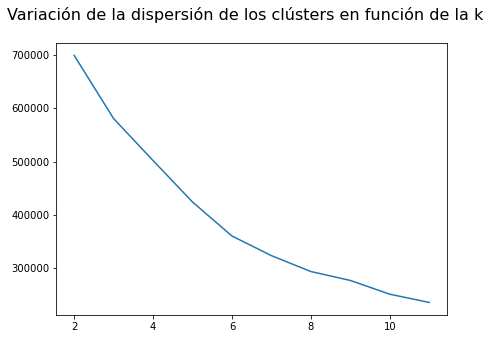

In [44]:
plot_elbow(sse)

## Processing

In [45]:
%%time
pipeline = Pipeline(steps=[
    ("FeatureGenerator", FeatureGenerator("pk_cid")),
    ("OutlierFilter", OutlierFilter(q=0.90, col_to_filter=["salary_mean", "salary_last"])),
    ("Scale", MinMaxScaler()),
    ("Clustering", KMeans(n_clusters=8))
])

processed_df = pipeline.fit(df)

Wall time: 10min 25s


In [46]:
%%time
X_processed = pipeline["FeatureGenerator"].transform(df)
X_scaled = pipeline["Scale"].transform(X_processed)

print(f"""
X_scaled.shape:    {X_scaled.shape}
X_processed.shape: {X_processed.shape}
""")

labels = pipeline["Clustering"].predict(X_scaled)
X_processed["cluster"] = labels


X_scaled.shape:    (456371, 32)
X_processed.shape: (456371, 32)

Wall time: 10min 50s


## Results observation

In [47]:
clustering_result = X_processed.copy(deep=True)
clustering_result.to_csv(f"{__PROCESSED_DATA_PATH__}/clustering_result.csv")
clustering_result

,active_customer_mean,active_customer_last,month_active,salary_mean,salary_last,age_mean,age_last,short_term_deposit,emc_account,em_account_p,...,credit_card_last,debit_card,debit_card_last,payroll,payroll_last,payroll_account,payroll_account_last,pension_plan,pension_plan_last,cluster
pk_cid,,,,,,,,,,,,,,,,,,,,,
15891,0.50,0,1,73136.48,73136.48,59.00,59,0.0,0.00,0.0,...,0,0.00,0,0.0,0,0.0,0,0.0,0,3
16063,0.71,0,4,117492.51,117492.51,62.00,62,0.0,0.00,0.0,...,0,0.00,0,0.0,0,0.0,0,0.0,0,3
16203,0.83,1,5,83697.15,83697.15,70.00,70,0.0,0.00,0.0,...,0,0.00,0,0.0,0,0.0,0,0.0,0,2
16502,0.89,1,8,126428.73,126428.73,57.89,58,0.0,0.56,0.0,...,0,0.00,0,0.0,0,0.0,0,0.0,0,2
17457,1.00,1,17,102405.75,102405.75,53.12,54,0.0,0.00,0.0,...,0,0.29,1,0.0,0,0.0,0,0.0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.00,0,0,115653.19,115653.19,52.00,52,0.0,0.00,0.0,...,0,0.00,0,0.0,0,0.0,0,0.0,0,3
1553686,0.00,0,0,119694.04,119694.04,30.00,30,0.0,0.00,0.0,...,0,0.00,0,0.0,0,0.0,0,0.0,0,3
1553687,0.00,0,0,101198.12,101198.12,21.00,21,0.0,0.00,0.0,...,0,0.00,0,0.0,0,0.0,0,0.0,0,3


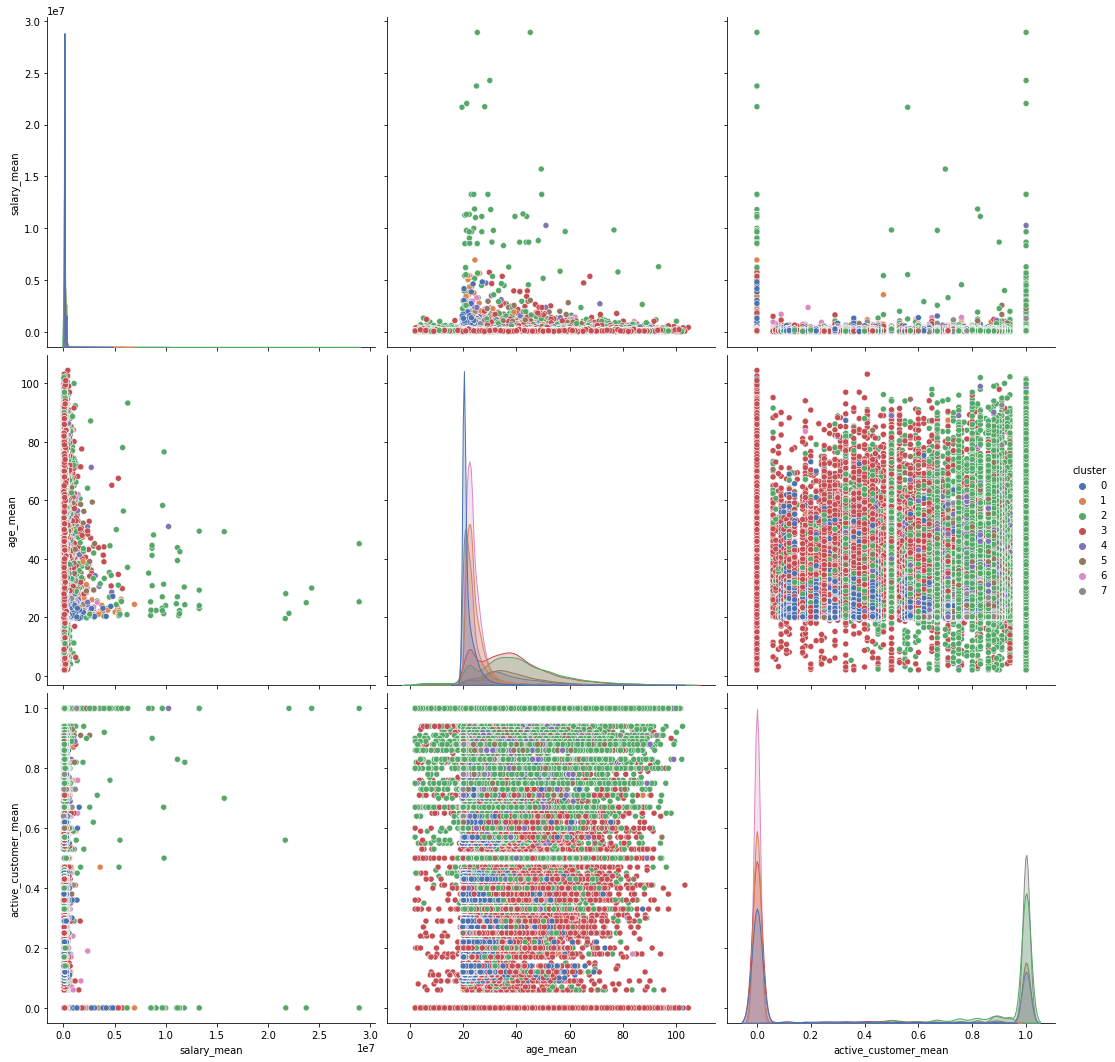

In [48]:
sns.pairplot(
    clustering_result,
    vars=["salary_mean", "age_mean", "active_customer_mean"],
    hue="cluster",
    height=5,
    palette="deep"
)

<AxesSubplot:xlabel='age_mean', ylabel='salary_mean'>

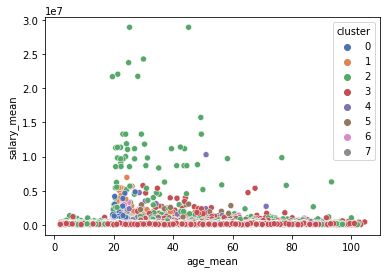

In [49]:
sns.scatterplot(data=clustering_result, x="age_mean", y="salary_mean", hue="cluster", palette="deep")

In [60]:
cluster_gb = clustering_result.groupby("cluster")

cluster_report = cluster_gb.agg(
    # active_customer
    active_customer_mean=("active_customer_mean", FeatureGenerator.get_mean),
    month_active=("month_active", np.median),

    # salary
    # salary_min=("salary_mean", np.min),
    salary_mean=("salary_mean", FeatureGenerator.get_mean),
    # salary_max=("salary_mean", np.max),

    # age
    age_mean=("age_mean", FeatureGenerator.get_mean),

    # short_term_deposit
    short_term_deposit=("short_term_deposit", FeatureGenerator.get_mean),

    # em accounts
    emc_account=("emc_account", FeatureGenerator.get_mean),
    em_account_p=("em_account_p", FeatureGenerator.get_mean),
    em_acount=("em_acount", FeatureGenerator.get_mean),

    # gender
    gender=("gender", FeatureGenerator.get_mean),

    # segment
    segment=("segment", FeatureGenerator.get_mode),
    segment_otros=("segment", lambda s: np.sum(s == 0)),
    segment_particulares=("segment", lambda s: np.sum(s == 1)),
    segment_universitarios=("segment", lambda s: np.sum(s == 2)),
    segment_top=("segment", lambda s: np.sum(s == 3)),

    # entry_channel
    ec_khe=("ec_khe", FeatureGenerator.get_mean),
    ec_khq=("ec_khq", FeatureGenerator.get_mean),
    ec_others=("ec_others", FeatureGenerator.get_mean),

    # loans
    loans=("loans", FeatureGenerator.get_mean),

    #mortgage
    mortgage=("mortgage", FeatureGenerator.get_mean),

    #funds
    funds=('funds', FeatureGenerator.get_mean),

    #securities
    securities=('securities', FeatureGenerator.get_mean),

    #long_term_deposit
    long_term_deposit=('long_term_deposit', FeatureGenerator.get_mean),

    #credit/debit card
    credit_card=('credit_card', FeatureGenerator.get_mean),
    debit_card=('debit_card', FeatureGenerator.get_mean),

    #payroll
    payroll=('payroll', FeatureGenerator.get_mean),
    payroll_account=('payroll_account', FeatureGenerator.get_mean),

    #pension_plan
    pension_plan=('pension_plan', FeatureGenerator.get_mean)
)
cluster_report.to_csv(f"{__PROCESSED_DATA_PATH__}/cluster_df.csv")

cluster_size = cluster_gb.size().to_frame()
cluster_size.columns = ["cluster_size"]

cluster_report = cluster_size.T.append(cluster_report.T)
cluster_report

cluster,0,1,2,3,4,5,6,7
cluster_size,56440.00,64290.00,66671.00,75496.00,20987.00,24295.00,87455.00,60737.00
active_customer_mean,0.06,0.03,0.93,0.06,0.96,0.96,0.02,0.96
month_active,0.00,0.00,14.00,0.00,17.00,17.00,0.00,17.00
salary_mean,115234.62,123637.29,129474.27,114204.12,115074.70,113159.43,116954.08,113782.36
age_mean,22.13,24.74,40.31,38.23,37.14,38.88,24.68,23.98
short_term_deposit,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00
emc_account,0.00,0.00,0.17,0.04,0.19,0.11,0.00,0.00
em_account_p,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
em_acount,0.63,0.76,0.79,0.22,0.21,0.91,0.75,0.96
gender,0.57,0.00,0.43,0.42,0.46,0.42,1.00,0.56


In [61]:
cluster_report.style.background_gradient(cmap='BuGn', axis=1)

cluster,0,1,2,3,4,5,6,7
cluster_size,56440.000000,64290.000000,66671.000000,75496.000000,20987.000000,24295.000000,87455.000000,60737.000000
active_customer_mean,0.060000,0.030000,0.930000,0.060000,0.960000,0.960000,0.020000,0.960000
month_active,0.000000,0.000000,14.000000,0.000000,17.000000,17.000000,0.000000,17.000000
salary_mean,115234.620000,123637.290000,129474.270000,114204.120000,115074.700000,113159.430000,116954.080000,113782.360000
age_mean,22.130000,24.740000,40.310000,38.230000,37.140000,38.880000,24.680000,23.980000
short_term_deposit,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000
emc_account,0.000000,0.000000,0.170000,0.040000,0.190000,0.110000,0.000000,0.000000
em_account_p,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
em_acount,0.630000,0.760000,0.790000,0.220000,0.210000,0.910000,0.750000,0.960000
gender,0.570000,0.000000,0.430000,0.420000,0.460000,0.420000,1.000000,0.560000
